Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Reshaping into (10, 15, 1) image tensors...


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 38s 12ms/step - accuracy: 0.9180 - auc_1: 0.6827 - loss: 0.2654 - val_accuracy: 0.9177 - val_auc_1: 0.7392 - val_loss: 0.2630
Epoch 2/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 32s 10ms/step - accuracy: 0.9197 - auc_1: 0.7300 - loss: 0.2535 - val_accuracy: 0.9177 - val_auc_1: 0.7435 - val_loss: 0.2540
Epoch 3/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 40s 13ms/step - accuracy: 0.9199 - auc_1: 0.7381 - loss: 0.2508 - val_accuracy: 0.9177 - val_auc_1: 0.7442 - val_loss: 0.2541
Epoch 4/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 37s 12ms/step - accuracy: 0.9195 - auc_1: 0.7386 - loss: 0.2512 - val_accuracy: 0.9177 - val_auc_1: 0.7460 - val_loss: 0.2537
Epoch 5/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 40s 12ms/step - accuracy: 0.9191 - auc_1: 0.7397 - loss: 0.2521 - val_accuracy: 0.9177 - val_auc_1: 0.7448 - val_loss: 0.2546
Epoch 6/50
3076/3076 ━━━━━━━━━━━━━━━━━━━━ 33s 11ms/step - accuracy: 0.9195 - auc_1: 0.7454 - loss: 0.2497 - val_accuracy: 0.9177 - val_auc_1: 0.7485 - val_loss:

/usr/local/lib/python3.11/dist-packages/shap/explainers/_deep/deep_tf.py:94: UserWarning: Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(100, 10, 15, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(200, 10, 15, 1))']
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: keras_tensor_7
Received: inputs=['Tensor(shape=(10, 10, 15

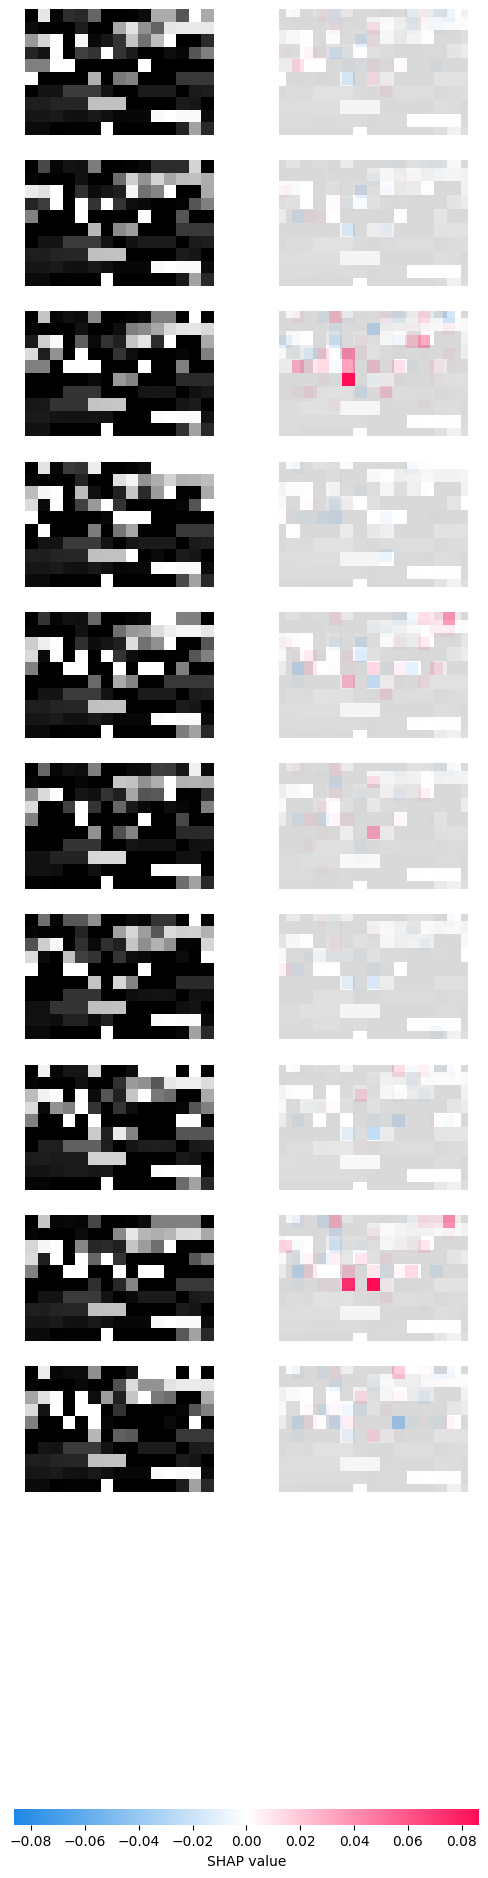

In [4]:
from google.colab import drive
drive.mount('/content/drive')

!pip install shap tensorflow scikit-learn pandas matplotlib

import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score
import matplotlib.pyplot as plt
import tensorflow as tf
import shap
import os

DATA_PATH = "/content/drive/MyDrive/home-credit-data/"
app = pd.read_csv(os.path.join(DATA_PATH, 'application_train.csv'))
bureau = pd.read_csv(os.path.join(DATA_PATH, 'bureau.csv'))
bureau_balance = pd.read_csv(os.path.join(DATA_PATH, 'bureau_balance.csv'))
previous = pd.read_csv(os.path.join(DATA_PATH, 'previous_application.csv'))
installments = pd.read_csv(os.path.join(DATA_PATH, 'installments_payments.csv'))

def aggregate(df, id_col):
    df_numeric = df.select_dtypes(include=[np.number])
    if id_col in df_numeric.columns:
        df_numeric = df_numeric.drop(columns=[id_col])
    return df_numeric.groupby(df[id_col]).mean().reset_index()

def safe_merge(main, other, key):
    for col in other.columns:
        if col in main.columns and col != key:
            other = other.drop(columns=col)
    return main.merge(other, on=key, how='left')

bureau_agg = aggregate(bureau, 'SK_ID_CURR')
bb_agg = aggregate(bureau_balance, 'SK_ID_BUREAU')
bureau_full = bureau.merge(bb_agg, on='SK_ID_BUREAU', how='left')
bureau_full_agg = aggregate(bureau_full, 'SK_ID_CURR')
previous_agg = aggregate(previous, 'SK_ID_CURR')
installments_agg = aggregate(installments, 'SK_ID_CURR')

data = app.copy()
data = safe_merge(data, bureau_agg, 'SK_ID_CURR')
data = safe_merge(data, bureau_full_agg, 'SK_ID_CURR')
data = safe_merge(data, previous_agg, 'SK_ID_CURR')
data = safe_merge(data, installments_agg, 'SK_ID_CURR')

for col in data.select_dtypes('object').columns:
    le = LabelEncoder()
    data[col] = le.fit_transform(data[col].astype(str))

data.fillna(data.mean(), inplace=True)
data.drop(columns=['SK_ID_CURR'], inplace=True)

y = data['TARGET']
X = data.drop(columns=['TARGET'])

actual_features = X.shape[1]
reshape_size = (actual_features // 15) * 15
reshape_height = reshape_size // 15

top_features = X.var().sort_values(ascending=False).head(reshape_size).index
X = X[top_features]

X = (X - X.min()) / (X.max() - X.min())

print(f"Reshaping into ({reshape_height}, 15, 1) image tensors...")
X_img = X.values.reshape(-1, reshape_height, 15, 1)


X_train, X_test, y_train, y_test = train_test_split(X_img, y, test_size=0.2, stratify=y, random_state=42)

model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(32, (3,3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], X_train.shape[3])),
    tf.keras.layers.MaxPooling2D((2,2)),
    tf.keras.layers.Conv2D(64, (3,3), activation='relu'),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', tf.keras.metrics.AUC()])
history = model.fit(X_train, y_train, epochs=50, batch_size=64, validation_split=0.2, verbose=1)

y_pred = model.predict(X_test).ravel()
y_pred_labels = (y_pred > 0.5).astype(int)

print("AUC:", roc_auc_score(y_test, y_pred))
print(classification_report(y_test, y_pred_labels))

explainer = shap.DeepExplainer(model, X_train[:100])
shap_values = explainer.shap_values(X_test[:10])
shap.image_plot(shap_values, X_test[:10])

Confusion Matrix:


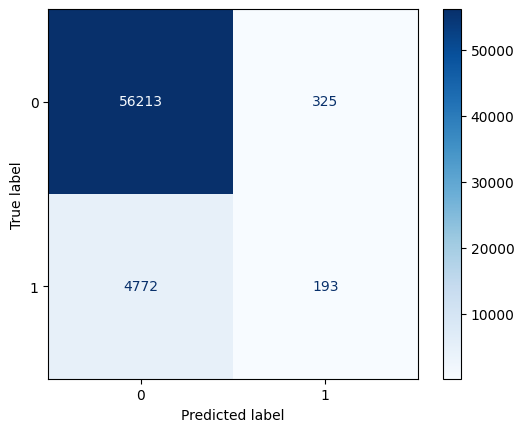

In [5]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, y_pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

print("Confusion Matrix:")
disp.plot(cmap=plt.cm.Blues)
plt.show()
